In [104]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json
import ast
import collections
from wordcloud import WordCloud
import wordcloud

In [105]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Get Kaggle dependencies

In [ ]:
!pip install kaggle
!mkdir .kaggle

In [163]:
import json
token = {"username":"chendazhangcmu","key":"6b09cd053db965e08e4284eab589bb85"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
 json.dump(token, file)
!chmod 600 /content/.kaggle/kaggle.json
!cp /content/.kaggle/kaggle.json /root/.kaggle/
!kaggle config set -n path -v /content

- path is now set to: /content


In [164]:
import os, zipfile, tarfile
os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""

In [ ]:
!kaggle datasets download -d saurabhshahane/spotgen-music-dataset

In [ ]:
!unzip spotgen-music-dataset.zip

### Load Data and some helper functions

In [ ]:
data_dir="SpotGenTrack/Data Sources/"
albums_data = pd.read_csv(data_dir+"spotify_albums.csv")
artists_data=pd.read_csv(data_dir+"spotify_artists.csv")
tracks_data= pd.read_csv(data_dir+"spotify_tracks.csv")


In [ ]:
artist_dic={}
for i in range(len(artists_data)):
  artist_dic[artists_data["id"][i]] = i
album_dic={}
for i in range(len(albums_data)):
  album_dic[albums_data["id"][i]]=i

In [ ]:
track_id= tracks_data.iloc[22]["artists_id"].split("""'""")[1]
x=artists_data.iloc[artist_dic[track_id]].to_dict()["genres"]
ast.literal_eval(x)[2]


'deep comedy'

In [ ]:
def get_track_id(tracks_data, artist_dic, index):
  #print(tracks_data.iloc[index]["artists_id"])
  return artist_dic[tracks_data.iloc[index]["artists_id"].split("""'""")[1]]

def retrieve_artists(tracks_data, artists_data, artist_dic):
  tracks2artists={}
  artists2tracks={}
  for i in range(len(tracks_data)):
    artist = artists_data.iloc[get_track_id(tracks_data, artist_dic,i)]
    tracks2artists[i]=artist.to_dict()
    artist_key=(artist["name"], artist["id"])
    if artist_key in artists2tracks:
      artists2tracks[artist_key].append(tracks_data.iloc[i].to_dict())
    else:
      artists2tracks[artist_key] =[tracks_data.iloc[i].to_dict()]
  return tracks2artists, artists2tracks

def get_genre_list(artists_data):
  genres = collections.defaultdict(list)
  for i in range(len(artists_data)):
    genre = artists_data.iloc[i]["genres"]
    for g in ast.literal_eval(genre):
      genres[g].append((artists_data.iloc[i]["name"],artists_data.iloc[i]["id"]))
  return dict(sorted(genres.items(), key=lambda x: len(x[1]), reverse=True))

  

In [ ]:
tracks2artists, artists2tracks = retrieve_artists(tracks_data, artists_data, artist_dic)

In [ ]:
genres = get_genre_list(artists_data)

### Helper functions for generating wordcloud

In [ ]:
def generate_wordcloud(lyrics):
  ### tracks: a list of track lyrics
  long_string = ",".join(lyrics)
  wordcloud = WordCloud(background_color="white", max_words=50, contour_width=3, contour_color='steelblue')
  wordcloud.generate(long_string)
  wordcloud.to_image()
  return wordcloud

def get_track_lyrics(tracks):
  lyrics=[]
  for track in tracks:
    lyrics.append(track["lyrics"])
  return lyrics

def get_lyrics_from_genres(genre):
  lyrics=[]
  for artist in genres[genre]:
    if artist in artists2tracks:
      lyrics+=get_track_lyrics(artists2tracks[artist])
  return lyrics



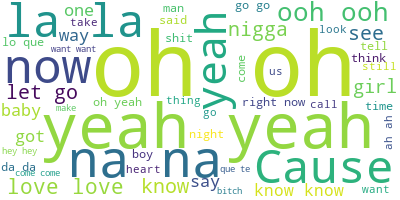

In [ ]:
lyrics = get_lyrics_from_genres("pop")
generate_wordcloud(lyrics).to_image()

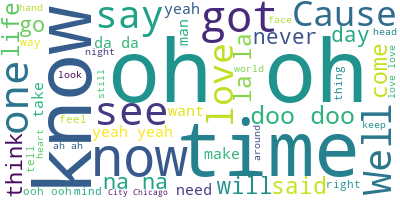

In [ ]:
lyrics = get_lyrics_from_genres("rock")
generate_wordcloud(lyrics).to_image()

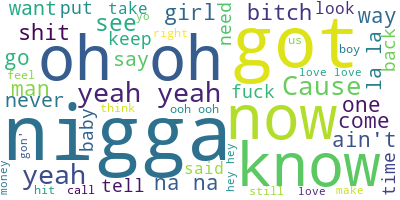

In [ ]:
lyrics = get_lyrics_from_genres("pop rap")
generate_wordcloud(lyrics).to_image()

### Get lyrics embeddings

In [ ]:
!pip install transformers

In [ ]:
!pip install -U sentence-transformers

In [4]:
from sentence_transformers import SentenceTransformer
import torch

In [ ]:
model_name="all-distilroberta-v1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_model = SentenceTransformer(model_name_or_path=model_name, device=device)

In [7]:
tracks = pd.read_csv("filtered_track_df.csv")

In [129]:
tracks["lyric_length"]=[len(item.split(" ")) for item in tracks.lyrics]

In [130]:
songs_with_lyrics=tracks[tracks.lyric_length>5]

In [10]:
lyrics = songs_with_lyrics.lyrics.to_list()
lyric_embedding = embedding_model.encode(lyrics)

In [16]:
embed = {}
for lyric,id in zip(lyric_embedding,songs_with_lyrics.id):
  embed[id]=lyric_embedding

In [11]:
import pickle
from tqdm import tqdm

In [13]:
pickle.dump( embed,open("lyrics_embeddings.pkl",'wb'))
songs_with_lyrics.to_csv("songs_with_lyrics.csv")

In [14]:
pickle.dump(embed, open("gdrive/MyDrive/05839/finalProject/embeddings/lyrics_embeddings.pkl",'wb'))

In [4]:
embed = pickle.load(open("lyrics_embeddings.pkl",'rb'))

In [32]:
diff=np.linalg.norm(lyric_embedding-lyric_embedding[0],axis=1)
ids = np.argpartition(diff,11)[:11]
print(ids)

[3859 9002    0 5288 6537 7604 7877  262 5553  419 2827]


In [12]:
neighbors={}
for i in tqdm(range(lyric_embedding.shape[0])):
  diff = np.linalg.norm(lyric_embedding-lyric_embedding[i],axis=1)
  ids = np.argpartition(diff, 11)[:11]
  track = songs_with_lyrics.iloc[i]["id"]
  neighbors[track]=[]
  for id in ids:
    if id==i:
      continue
    else:
      neighbors[track].append((songs_with_lyrics.iloc[id]["name"],songs_with_lyrics.iloc[id].id))

      






100%|██████████| 9049/9049 [02:38<00:00, 56.98it/s]


In [15]:
def get_lyrics(id):
  lyric=songs_with_lyrics[songs_with_lyrics["id"]==id]["lyrics"].item()
  return "\n".join(lyric.split("\n")[:10])



    

In [23]:
pickle.dump(neighbors,open("gdrive/MyDrive/05839/finalProject/lyrics_10nn.pkl",'wb'))

### Sentiment Analysis of Lyrics

In [67]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
stopword=stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
tracks['genres'] = tracks.genres.apply(lambda x: [i[1:-1] for i in str(x)[1:-1].split(", ")])
exploded_track_df = tracks.explode("genres")

In [28]:
genre_names = ['Anime', 'Dance Pop', 'Electronic', 'Electropop', 'Hip Hop', 'Jazz', 'J-pop', 'K-pop', 'Latin', 'Pop', 'Pop Rap', 'R&B', 'Rock']

In [84]:
def get_genre_lyrics(genre):
  lyrics =exploded_track_df[(exploded_track_df["genres"]==genre.lower()) & (exploded_track_df["lyric_length"]>5)]["lyrics"].to_list()
  return lyrics

def clean_lyrics(lyrics):
  ret=[]
  for lyric in lyrics:
    lyric=lyric.replace("\r\n","")
    words=lyric.split(" ")
    filtered_words = [word for word in words if word not in stopword and len(word) > 1 and word not in ['na','la']]
    ret.append(" ".join(filtered_words))
  return ret 
def generate_wordcloud(lyrics):
  ### tracks: a list of track lyrics
  long_string = ",".join(lyrics)
  wordcloud = WordCloud(background_color="white", max_words=75, contour_width=3, contour_color='steelblue')
  wordcloud.generate(long_string)
  wordcloud.to_image()
  return wordcloud

In [74]:
cleaned_lyrics={}
for genre in tqdm(genre_names[1:]):
  cleaned_lyrics[genre]=clean_lyrics(get_genre_lyrics(genre))


100%|██████████| 12/12 [00:09<00:00,  1.31it/s]


In [80]:
pickle.dump(cleaned_lyrics, open("gdrive/MyDrive/05839/finalProject/cleaned_lyrics.pkl",'wb'))

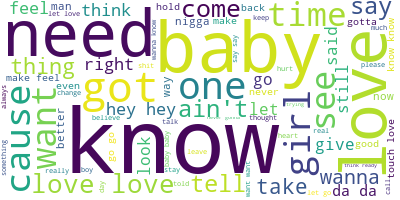

In [85]:
words=cleaned_lyrics["R&B"]
generate_wordcloud(words).to_image()

In [127]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [128]:
sid = SentimentIntensityAnalyzer()

In [169]:
import transformers

In [176]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [178]:
classifier = transformers.pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [99]:
sentiment_result={}
for genre in genre_names[1:]: 
  sentiment_result[genre]={}
  lyrics=get_genre_lyrics(genre)
  num_positive = 0
  num_negative = 0
  num_neutral = 0
  sentences=[]
  for lyric in lyrics:
    for sentence in lyric.split("\r\n"):
      comp = sid.polarity_scores(sentence)
      comp = comp['compound']
      sentences.append((sentence, comp))
      if comp >= 0.3:
          num_positive += 1
      elif comp > -0.3 and comp < 0.3:
          num_neutral += 1
      else:
          num_negative += 1
  num_total = num_negative + num_neutral + num_positive
  percent_negative = (num_negative/float(num_total))*100
  percent_neutral = (num_neutral/float(num_total))*100
  percent_positive = (num_positive/float(num_total))*100
  sentences=sorted(sentences, key=lambda x:x[1])
  sentiment_result[genre]["positive_sentences"]=sentences[-100::10]
  sentiment_result[genre]["negative_sentences"]=sentences[:100:10]
  sentiment_result[genre]["sentiment_distribution"]=(percent_negative, percent_neutral, percent_positive)
  print(genre)
  print(percent_negative, percent_neutral, percent_positive)


Dance Pop
8.107917858536991 74.89489143581179 16.997190705651224
Electronic
8.001739508588823 76.19047619047619 15.807784300934985
Electropop
8.995306962934585 75.26673690259554 15.737956134469878
Hip Hop
14.106434982644236 68.58709717172961 17.30646784562614
Jazz
6.257982120051085 76.24521072796935 17.496807151979567
J-pop
4.858498282349092 84.93374775069525 10.207753966955668
K-pop
2.7331904742651516 88.58407795253306 8.682731573201794
Latin
3.494324287361038 91.52355274212141 4.982122970517555
Pop
9.008068297729372 74.45071280437399 16.541218897896634
Pop Rap
12.051678308709898 70.80546454843297 17.142857142857142
R&B
8.582112964148125 72.07895694512418 19.338930090727704
Rock
11.499598414384538 74.0018654299557 14.498536155659766


In [ ]:
sentiment_result={}
for genre in genre_names[1:]: 
  sentiment_result[genre]={}
  lyrics=get_genre_lyrics(genre)
  num_positive = 0
  num_negative = 0
  num_neutral = 0
  sentences=[]
  for lyric in tqdm(lyrics):
    sentences= lyric.split("\r\n")
    comps=classifier(sentences)
    for i, comp in enumerate(comps):
      
      comp = comp['score']
      sentences.append((sentences[i], comp))
      if comp >= 0.3:
          num_positive += 1
      elif comp > -0.3 and comp < 0.3:
          num_neutral += 1
      else:
          num_negative += 1
  num_total = num_negative + num_neutral + num_positive
  percent_negative = (num_negative/float(num_total))*100
  percent_neutral = (num_neutral/float(num_total))*100
  percent_positive = (num_positive/float(num_total))*100
  sentences=sorted(sentences, key=lambda x:x[1])
  sentiment_result[genre]["positive_sentences"]=sentences[-100::10]
  sentiment_result[genre]["negative_sentences"]=sentences[:100:10]
  sentiment_result[genre]["sentiment_distribution"]=(percent_negative, percent_neutral, percent_positive)
  print(genre)
  print(percent_negative, percent_neutral, percent_positive)

In [103]:
pickle.dump(sentiment_result, open("gdrive/MyDrive/05839/finalProject/lyric_sentiments.pkl",'wb'))

In [107]:
lyric_sentiment = pickle.load(open("gdrive/MyDrive/05839/finalProject/lyric_sentiments.pkl","rb"))

In [ ]:
lyric_sentiment

In [125]:
def plot_sentiment_distribution():
    df = pd.DataFrame(columns=('genre','Positive','Neutral',"Negative"))
    for i,genre in enumerate(lyric_sentiment):
        df.loc[i]=(genre, *lyric_sentiment[genre]["sentiment_distribution"])
    axs = df.plot.barh(x='genre', stacked=True, )
    axs.set_title("Lyrics Sentiment Distribution among different Genres")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

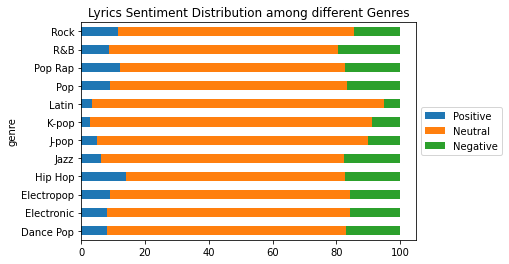

In [126]:
plot_sentiment_distribution()

In [138]:
song_sentiments={}
for song, lyric in zip(songs_with_lyrics["name"],songs_with_lyrics.lyrics):
  song_sentiments[song]=[]
  for sentence in lyric.split("\r\n"):
      if len(sentence)<2:
        continue
      comp = sid.polarity_scores(sentence)
      comp = comp['compound']
      song_sentiments[song].append((sentence, comp))

    
      

    

In [140]:
pickle.dump(song_sentiments,open("gdrive/MyDrive/05839/finalProject/song_sentiments.pkl",'wb'))

In [142]:
lyrics_knn=pickle.load(open("gdrive/MyDrive/05839/finalProject/lyrics_10nn.pkl",'rb'))

In [158]:
def get_lyrics(id):
  
  lyric = exploded_track_df[exploded_track_df["id"] == id].iloc[0]["lyrics"]
  return "\n".join(lyric.split("\r\n")[:10])

In [159]:
get_lyrics('4JH1M62gVDNDhDAUiQB3Qv')

'\nDame la muerte chiquita\nDame la muerte pequeña\nY así tal vez en tus brazos alcanzaré gracia plena\nSu esencia de alta marea\nSus besos de tamarindo\nSus pestañas dos palmeras a cuyo vaivén me rindo\nDicen que usted trae las sombras\nY por dentro está toda herida\nDame la muerte chiquita'